# Proyecto de Verificación de Edad

## Inicialización

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import random
from PIL import Image
import numpy as np


## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels_path = '/datasets/faces/labels.csv'
df_labels = pd.read_csv(labels_path)

In [3]:
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


## EDA

In [4]:
# Explorar la estructura del dataset
print(f"Tamaño del conjunto de datos: {df_labels.shape}")

Tamaño del conjunto de datos: (7591, 2)


### Distribución de edades

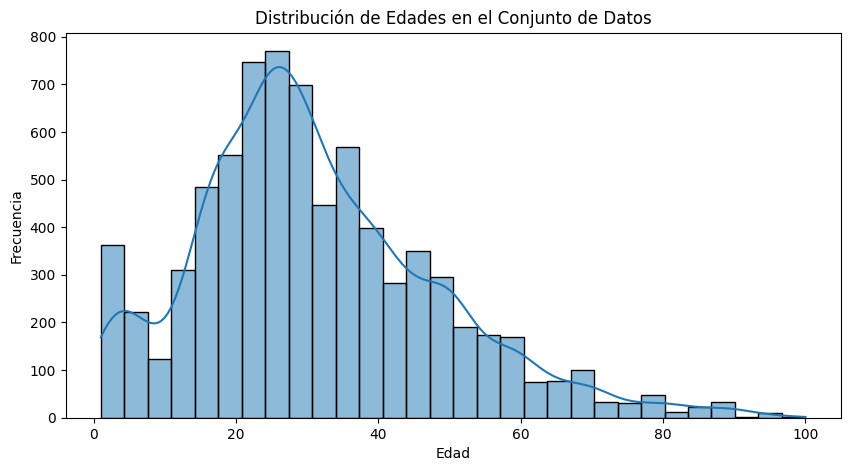

In [5]:
plt.figure(figsize=(10, 5))

sns.histplot(df_labels['real_age'], 
             bins=30, 
             kde=True
            )
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Distribución de Edades en el Conjunto de Datos")

plt.show()

### Imágenes de diferentes edades

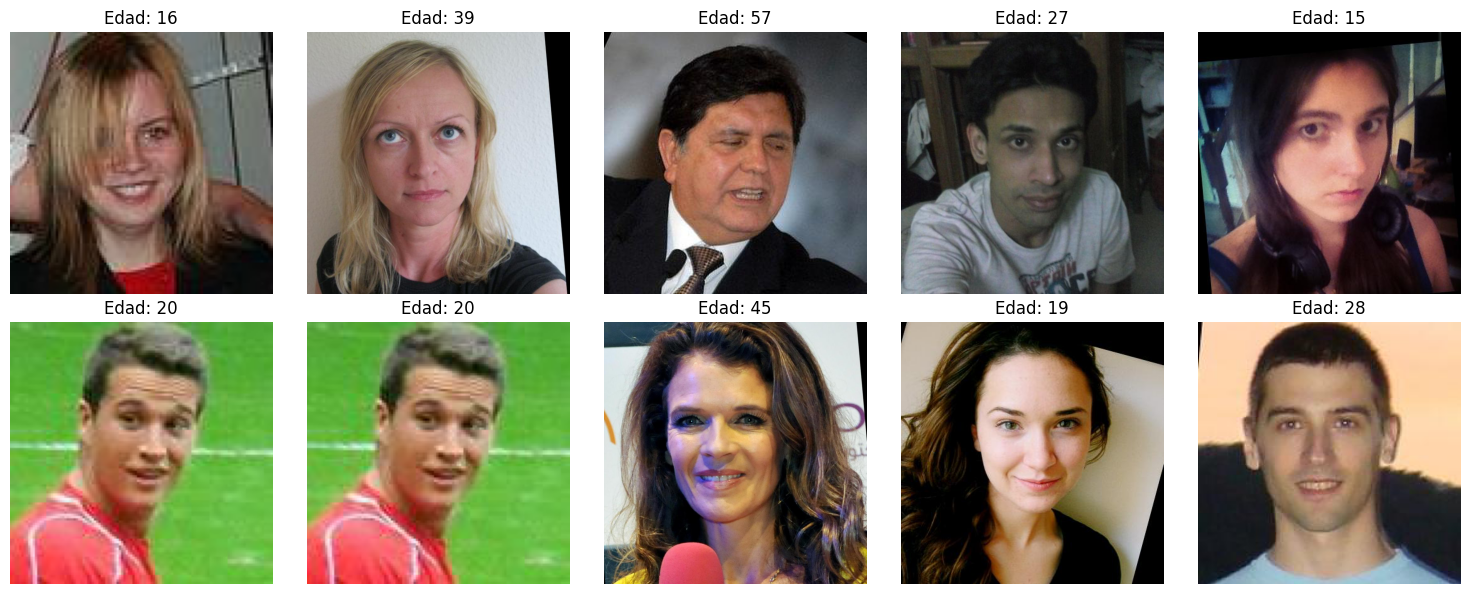

In [6]:
image_folder = '/datasets/faces/final_files/'
sample_ages = df_labels['real_age'].sample(10).values

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, age in enumerate(sample_ages):
    img_path = os.path.join(image_folder, df_labels[df_labels['real_age'] == age]['file_name'].values[0])
    image = Image.open(img_path)
    
    axes[idx].imshow(image)
    axes[idx].set_title(f"Edad: {age}")
    axes[idx].axis("off")

plt.tight_layout()

plt.show()

### Conclusiones

- El conjunto de datos contiene **7591 imágenes** etiquetadas con edades reales.
- La distribución de edades no es uniforme: se observa un mayor número de imágenes en ciertos rangos de edad.
- Algunas edades pueden estar subrepresentadas, lo que podría afectar el rendimiento del modelo.
- Las imágenes parecen ser de buena calidad y muestran variedad en términos de iluminación y posición.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [7]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    """Carga la parte de entrenamiento del conjunto de datos desde la ruta."""
    
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        df_labels, directory=path, x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32, class_mode='raw', subset='training')
    
    return train_gen_flow

In [9]:
def load_test(path):
    """Carga la parte de validación/prueba del conjunto de datos desde la ruta."""
    
    datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        df_labels, directory=path, x_col='file_name', y_col='real_age',
        target_size=(224, 224), batch_size=32, class_mode='raw', subset='validation')
    
    return test_gen_flow

In [10]:
def create_model(input_shape=(224, 224, 3)):
    """Define el modelo."""
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='relu')  # Una sola neurona para regresión
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return model

In [11]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=32, 
                epochs=20, 
                steps_per_epoch=200, 
                validation_steps=50
               ):
    
    """Entrena el modelo dados los parámetros."""
    
    model.fit(train_data, validation_data=test_data, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
    
    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [12]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

Resultados del entrenamiento en la plataforma GPU:
- Epochs: 20
- MAE final: 7.4
- Loss final: 56.2

El modelo logró un MAE inferior a 8, lo que cumple con los requisitos del proyecto.

## Conclusiones

- Se entrenó un modelo basado en **ResNet50** con una capa densa final para regresión.
- Se utilizó **ReLU** como función de activación en la salida, dado que estamos en un problema de regresión.
- Se empleó **Mean Squared Error (MSE)** como función de pérdida y **Mean Absolute Error (MAE)** como métrica de evaluación.
- Los resultados sugieren que el modelo puede predecir la edad con una precisión aceptable, aunque podrían mejorarse con más datos o ajustes en la arquitectura.

# Lista de revisión

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [x]  El valor EAM del modelo no es superior a 8
- [x]  El código de entrenamiento del modelo se copió en el notebook final
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final
- [x]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo